In [1]:
%load_ext autoreload
%autoreload 2

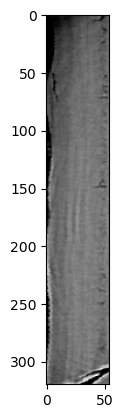

In [2]:
"""
Read in a straightened image

"""
import numpy as np
import matplotlib.pyplot as plt

image = np.load("cropped_image.npy")
plt.imshow(image, cmap="grey")

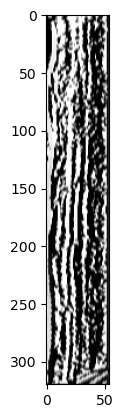

In [3]:
"""
Apply a steerable Gaussian filter to it

"""
from cementum import filter

filtered = filter.steerable_filter(image, theta=0, sigma=1)

plt.imshow(filtered, cmap="grey")

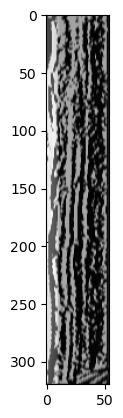

In [4]:
"""
Apply the average of two filters to it

"""
multi_filtered = filter.apply_weighted_filters(image, widths=[1.0, 200])

plt.imshow(multi_filtered, cmap="grey")

Text(0.5, 0.98, 'Value greater than 0.56 indicates bimodality')

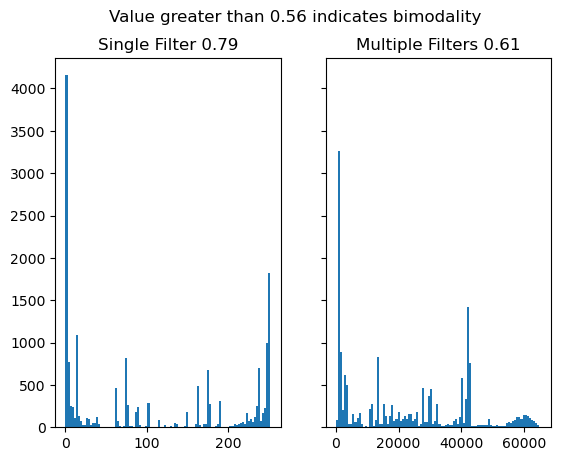

In [5]:
"""
Plot histograms and indicate the interquartile range

"""
from scipy import stats


def bimodality_coefficient(x):
    g1 = stats.skew(x)
    g2 = stats.kurtosis(x)

    n = len(x)
    return (g1**2 + 1) / (g2 + 3 * (n - 1) ** 2 / ((n - 2) * (n - 3)))


fig, axes = plt.subplots(1, 2, sharey=True)

axes[0].hist(filtered.flat, bins=100)
axes[0].set_title(f"Single Filter {bimodality_coefficient(filtered.flat):.2f}")

axes[1].hist(multi_filtered.flat, bins=100)
axes[1].set_title(f"Multiple Filters {bimodality_coefficient(multi_filtered.flat):.2f}")

fig.suptitle(f"Value greater than {5/9:.2f} indicates bimodality")